Run Palantir and MAGIC (ABpxp)
---
Run [Palantir](https://www.nature.com/articles/s41587-019-0068-4) to get a pseudotime, and [MAGIC](https://doi.org/10.1016/j.cell.2018.05.061) to get imputed gene expression, useful for visualizing gene expression trends. Note: we only use imputed gene expression to visualize gene expression trends. 

# Preliminaries

## Import packages

In [1]:
# single cell packages
import scanpy as sc

# rest
import numpy as np
import pandas as pd
import scvelo as scv
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt

## Dependencies

This notebook depends on [ML_2024-03-11_compute_couplings.ipynb](ML_2024-03-11_compute_couplings.ipynb). 

## Define utility functions

## Set up paths

Define the paths to load data, cache results and write figure panels.

In [2]:
sys.path.insert(
    0, "../../"
)  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, FIG_DIR

FIG_DIR = FIG_DIR / "packer_c_elegans"
DATA_DIR = DATA_DIR / "packer_c_elegans"

Set up the paths to save figures.

In [3]:
sc.settings.figdir = str(FIG_DIR)

## Set global parameters

In [39]:
# number of neighbors
knn = 30

# number of waypoings samples
num_waypoints = 1200

# parallelisation
n_jobs = -1

# scaling
scale_components = True

# whether to write Palantir's pseudotime and MAGIC imputed data
write_data = True

# whether to recompute Palantir's waypoint cells
write_waypoints = False
recompute_waypoints = False

In [5]:
scv.settings.set_figure_params(
    "scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=25, color_map="viridis"
)
scv.settings.plot_prefix = ""

## Import the data

Import the AnnData object, created in previous notebooks. 

In [6]:
adata = sc.read(DATA_DIR / "ML_2024-03-11_c_elegans_abpxp_moslin_adata.h5ad")
adata

AnnData object with n_obs × n_vars = 6476 × 20222
    obs: 'idx', 'barcode', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted', 'random_precise_lineage', 'clusters', 'coarse_clusters', 'assigned_batch_time', 'marginals', 'time_point'
    var: 'Ensembl', 'gene_short_name', 'Symbol', 'Family', 'Protein', 'Entrez_ID', 'TF', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'coarse_clusters_colors', 'hvg', 'log1p', 'pca', 'raw.embryo.time_colors', 'time_point_colors'
    obsm: 'X_pca', 'X_umap'

Check the matplotlib backend. 

In [7]:
mpl.rcParams["backend"]

'module://matplotlib_inline.backend_inline'

# Prepare for running Palantir

In [8]:
import palantir

print(f"palantir=={palantir.__version__}")

palantir==1.3.2


## Compute PCA, Diffmap and Multiscale data

Compute PCA representation and Diffmap

In [12]:
sc.pp.pca(
    adata, use_highly_variable=True, n_comps=500
)  # need to recompute this to have enough components
n_comps = np.where(np.cumsum(adata.uns["pca"]["variance_ratio"]) > 0.85)[0][0]
print(f"This selects {n_comps} PCs. ")
dm_res = palantir.utils.run_diffusion_maps(
    pd.DataFrame(adata.obsm["X_pca"][:, :n_comps], index=adata.obs_names),
    n_components=20,
)

This selects 325 PCs. 


Use the diffusion components to construct a denoised KNN graph and data representation:

In [13]:
# comptue multiscale space in diffusion map space
ms_data = palantir.utils.determine_multiscale_space(dm_res, n_eigs=15)
ms_data.shape

(6476, 14)

## Visualise multiscale data

Visualise multiscale components in the UMAP

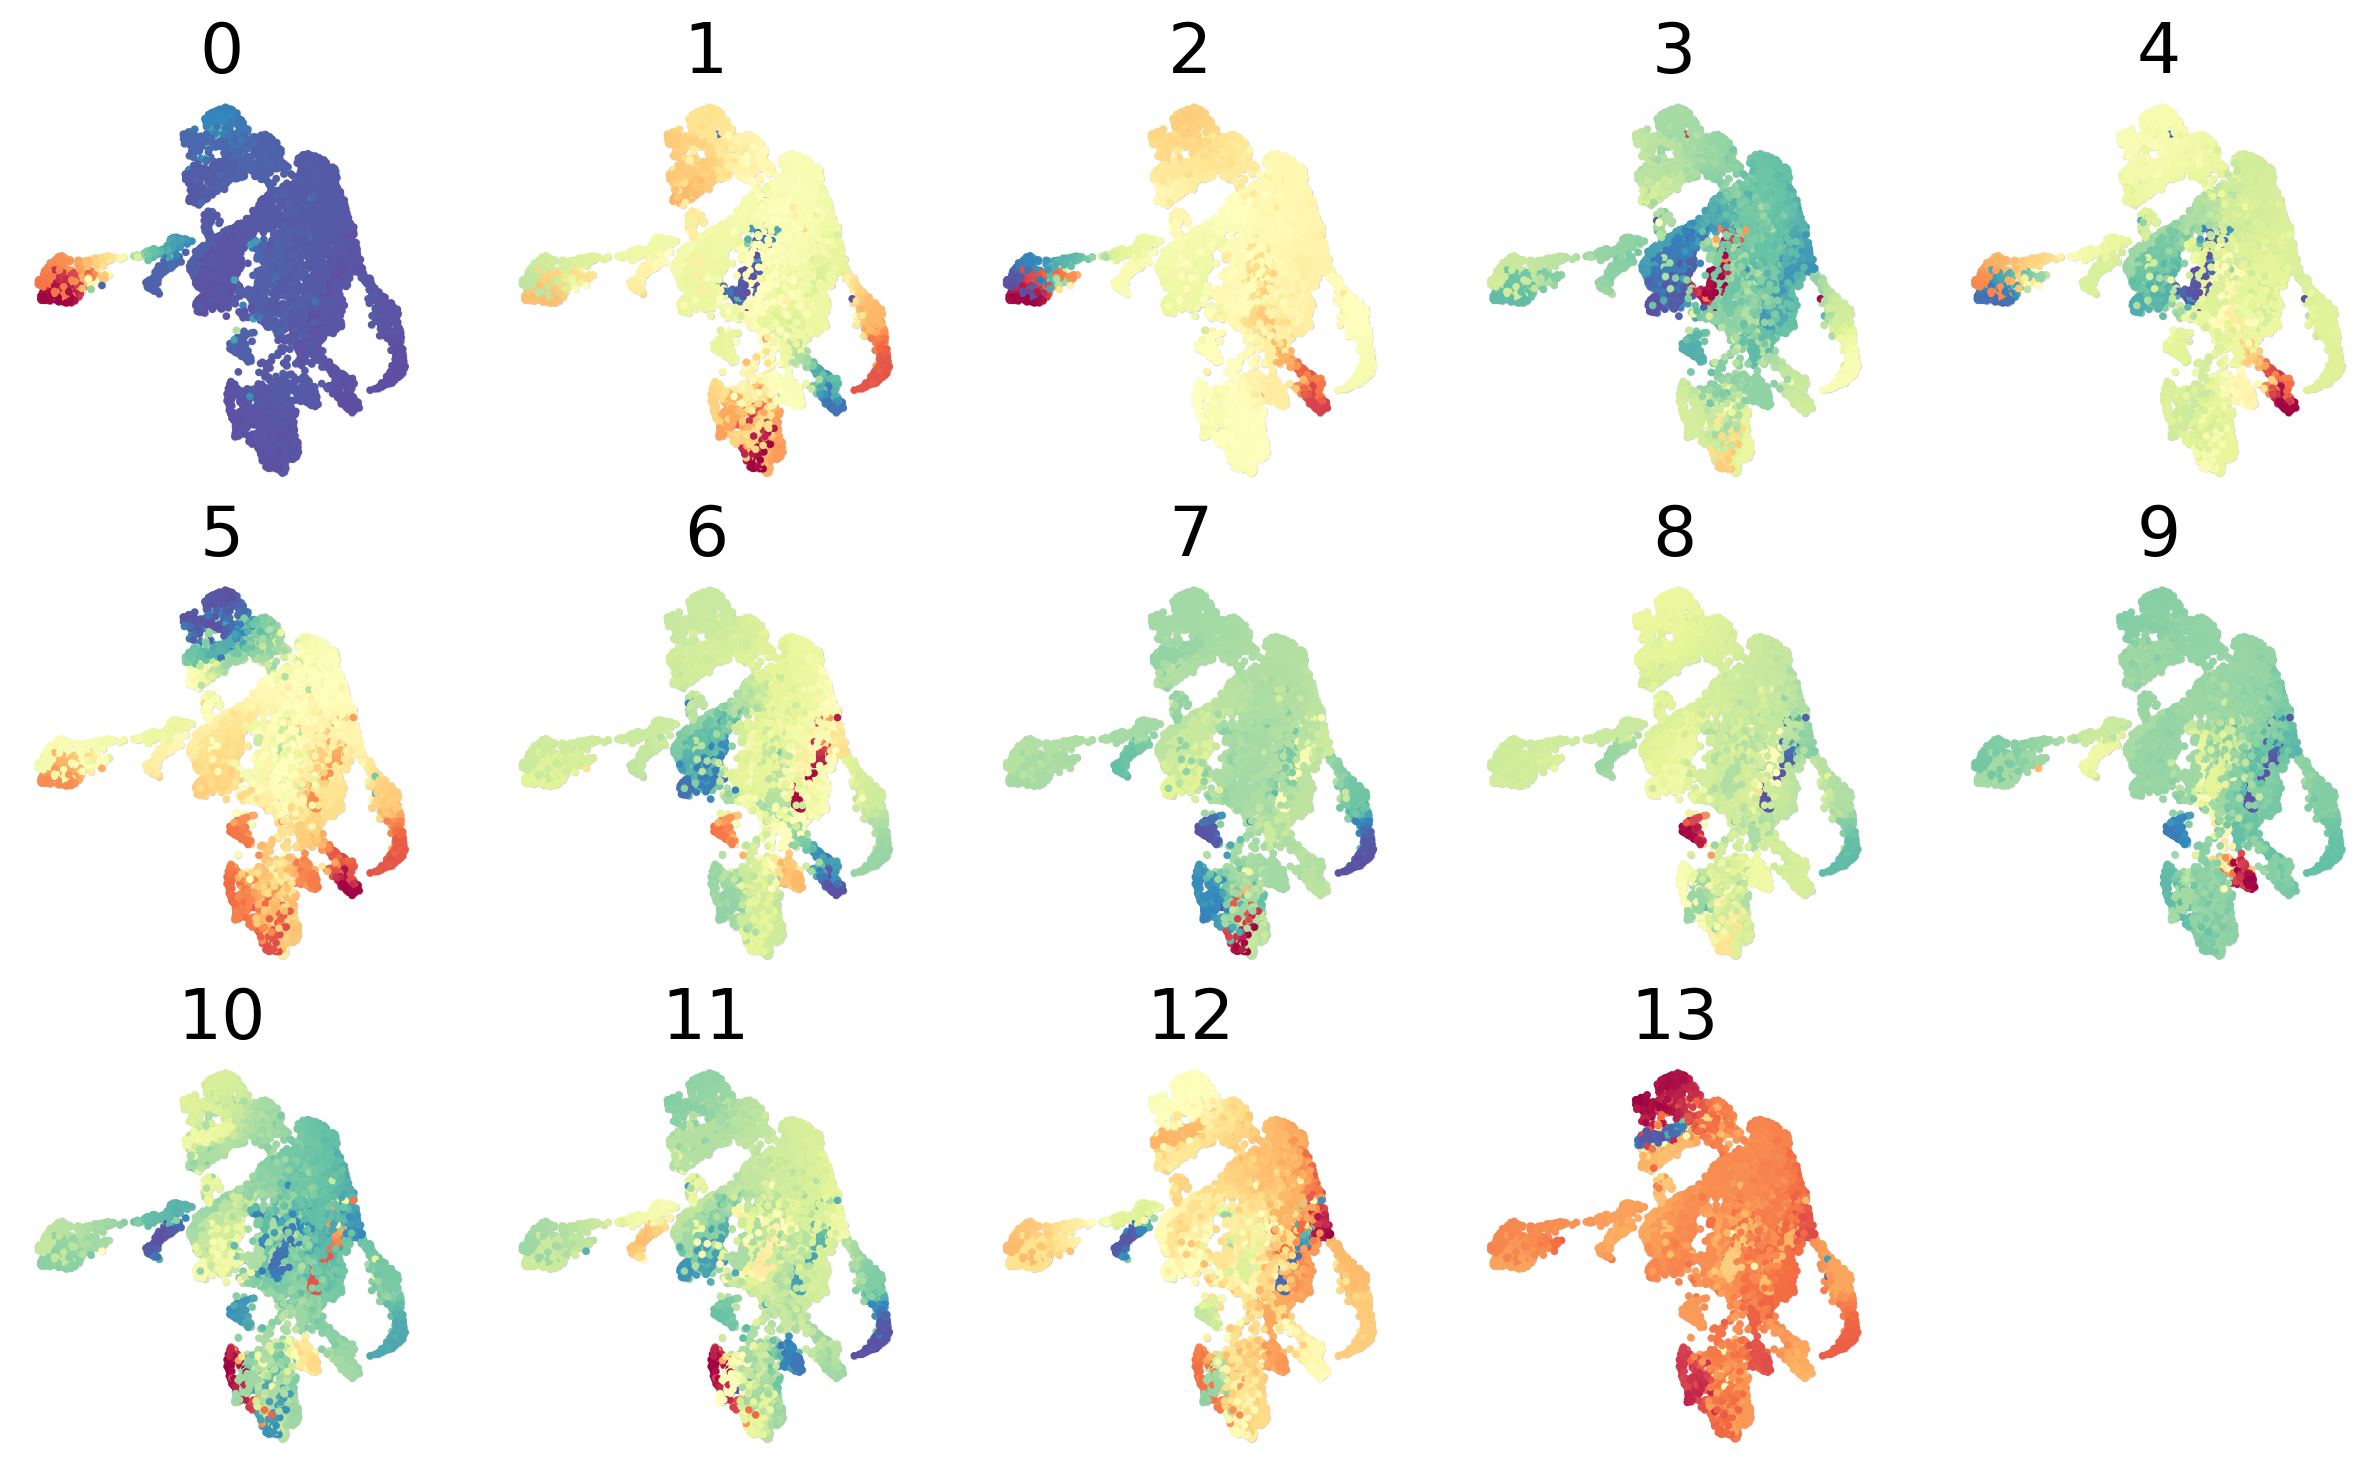

In [15]:
umap = pd.DataFrame(adata.obsm["X_umap"], index=adata.obs_names, columns=["x", "y"])
palantir.plot.plot_gene_expression(ms_data, umap, ms_data.columns)
plt.show()

## Define an initial cell

Let's choose a random early cell:

In [16]:
adata.obs.loc[adata.obs["raw.embryo.time"] == 120]

,idx,barcode,n.umi,time.point,batch,Size_Factor,cell.type,cell.subtype,plot.cell.type,raw.embryo.time,...,embryo.time.bin,raw.embryo.time.bin,lineage,passed_initial_QC_or_later_whitelisted,random_precise_lineage,clusters,coarse_clusters,assigned_batch_time,marginals,time_point
cell,,,,,,,,,,,,,,,,,,,,,
AGCTCCTCAAGCCCAC-r17,61078,AGCTCCTCAAGCCCAC-r17,4688,mixed,0,2.944667,NaN,NaN,NaN,120,...,130-170,100-130,ABpxppa,True,ABplppa,Progenitor cell,Progenitor cell,170,0.014523,170
AGCTCTCAGCGGCTTC-r17,61088,AGCTCTCAGCGGCTTC-r17,5625,mixed,0,3.520920,NaN,NaN,NaN,120,...,130-170,100-130,ABpxpap,True,ABprpap,Progenitor cell,Progenitor cell,170,0.004030,170
CATCAAGCATCTGGTA-r17,62469,CATCAAGCATCTGGTA-r17,9265,mixed,0,5.830955,NaN,NaN,NaN,120,...,130-170,100-130,ABpxppp,True,ABprppp,Progenitor cell,Progenitor cell,170,0.008185,170
CGTTCTGGTCTCTCGT-r17,63784,CGTTCTGGTCTCTCGT-r17,9321,mixed,0,5.851042,NaN,NaN,NaN,120,...,130-170,100-130,ABpxppp,True,ABprppp,Progenitor cell,Progenitor cell,170,0.011315,170
CTCATTATCCCTTGTG-r17,64019,CTCATTATCCCTTGTG-r17,7696,mixed,0,4.844169,NaN,NaN,NaN,120,...,130-170,100-130,ABpxppa,True,ABprppa,Progenitor cell,Progenitor cell,170,0.016604,170
TTATGCTAGAGCTATA-r17,68266,TTATGCTAGAGCTATA-r17,8799,mixed,0,5.511442,NaN,NaN,NaN,120,...,130-170,100-130,ABpxppa,True,ABplppa,Progenitor cell,Progenitor cell,170,0.014523,170


(<Figure size 400x400 with 1 Axes>, <Axes: >)

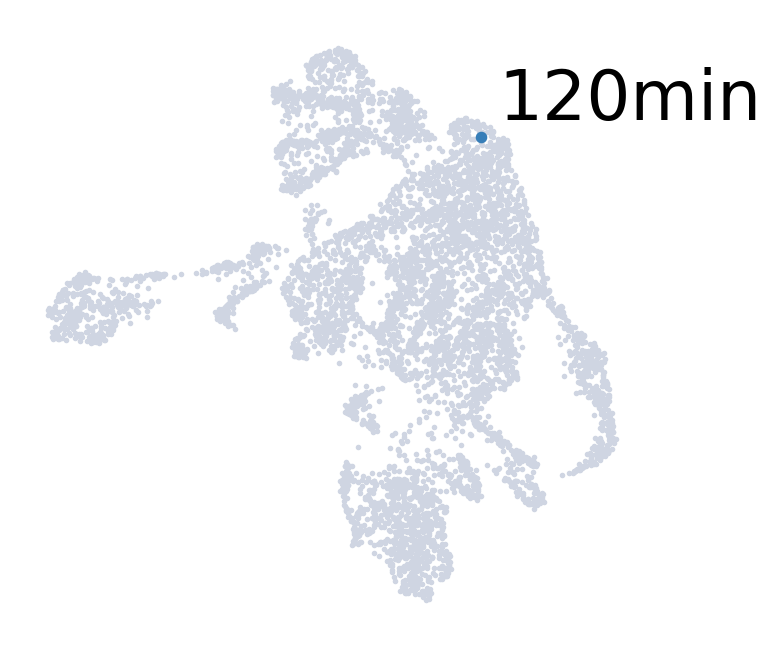

In [20]:
initial_state = pd.Series(
    ["120min"],
    index=["AGCTCCTCAAGCCCAC-r17"],
)

palantir.plot.highlight_cells_on_umap(adata, initial_state)

# Run Palantir

## Compute a pseudotime 

Note: Palantir is not exactly reproducible if you don't save the waypoint cells (we originally used Version 1.1, the problem might have been fixed in the meantime). The waypoint cells we import here are included in this repository in `data/packer_c_elegans`. 

In [21]:
import random

random.seed = 0
np.random.seed(0)

if not recompute_waypoints:
    print("Loading waypoint cells from file")
    waypoints = pd.Index(
        pd.read_csv(DATA_DIR / "palantir" / "ML_2023-03-30_waypoints.csv", index_col=0)[
            "0"
        ]
    )

pr_res = palantir.core.run_palantir(
    ms_data,
    root_cell,
    terminal_states=None,
    knn=knn,
    num_waypoints=num_waypoints if recompute_waypoints else waypoints,
    n_jobs=n_jobs,
    scale_components=scale_components,
    use_early_cell_as_start=True,
)

if write_waypoints:
    print("Writing waypoint cells to file")
    pd.Series(pr_res.waypoints).to_csv(DATA_DIR / "palantir" / "waypoints.csv")

Loading waypoint cells from file
Sampling and flocking waypoints...
Time for determining waypoints: 1.7754236857096355e-05 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.14873040517171224 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9993
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


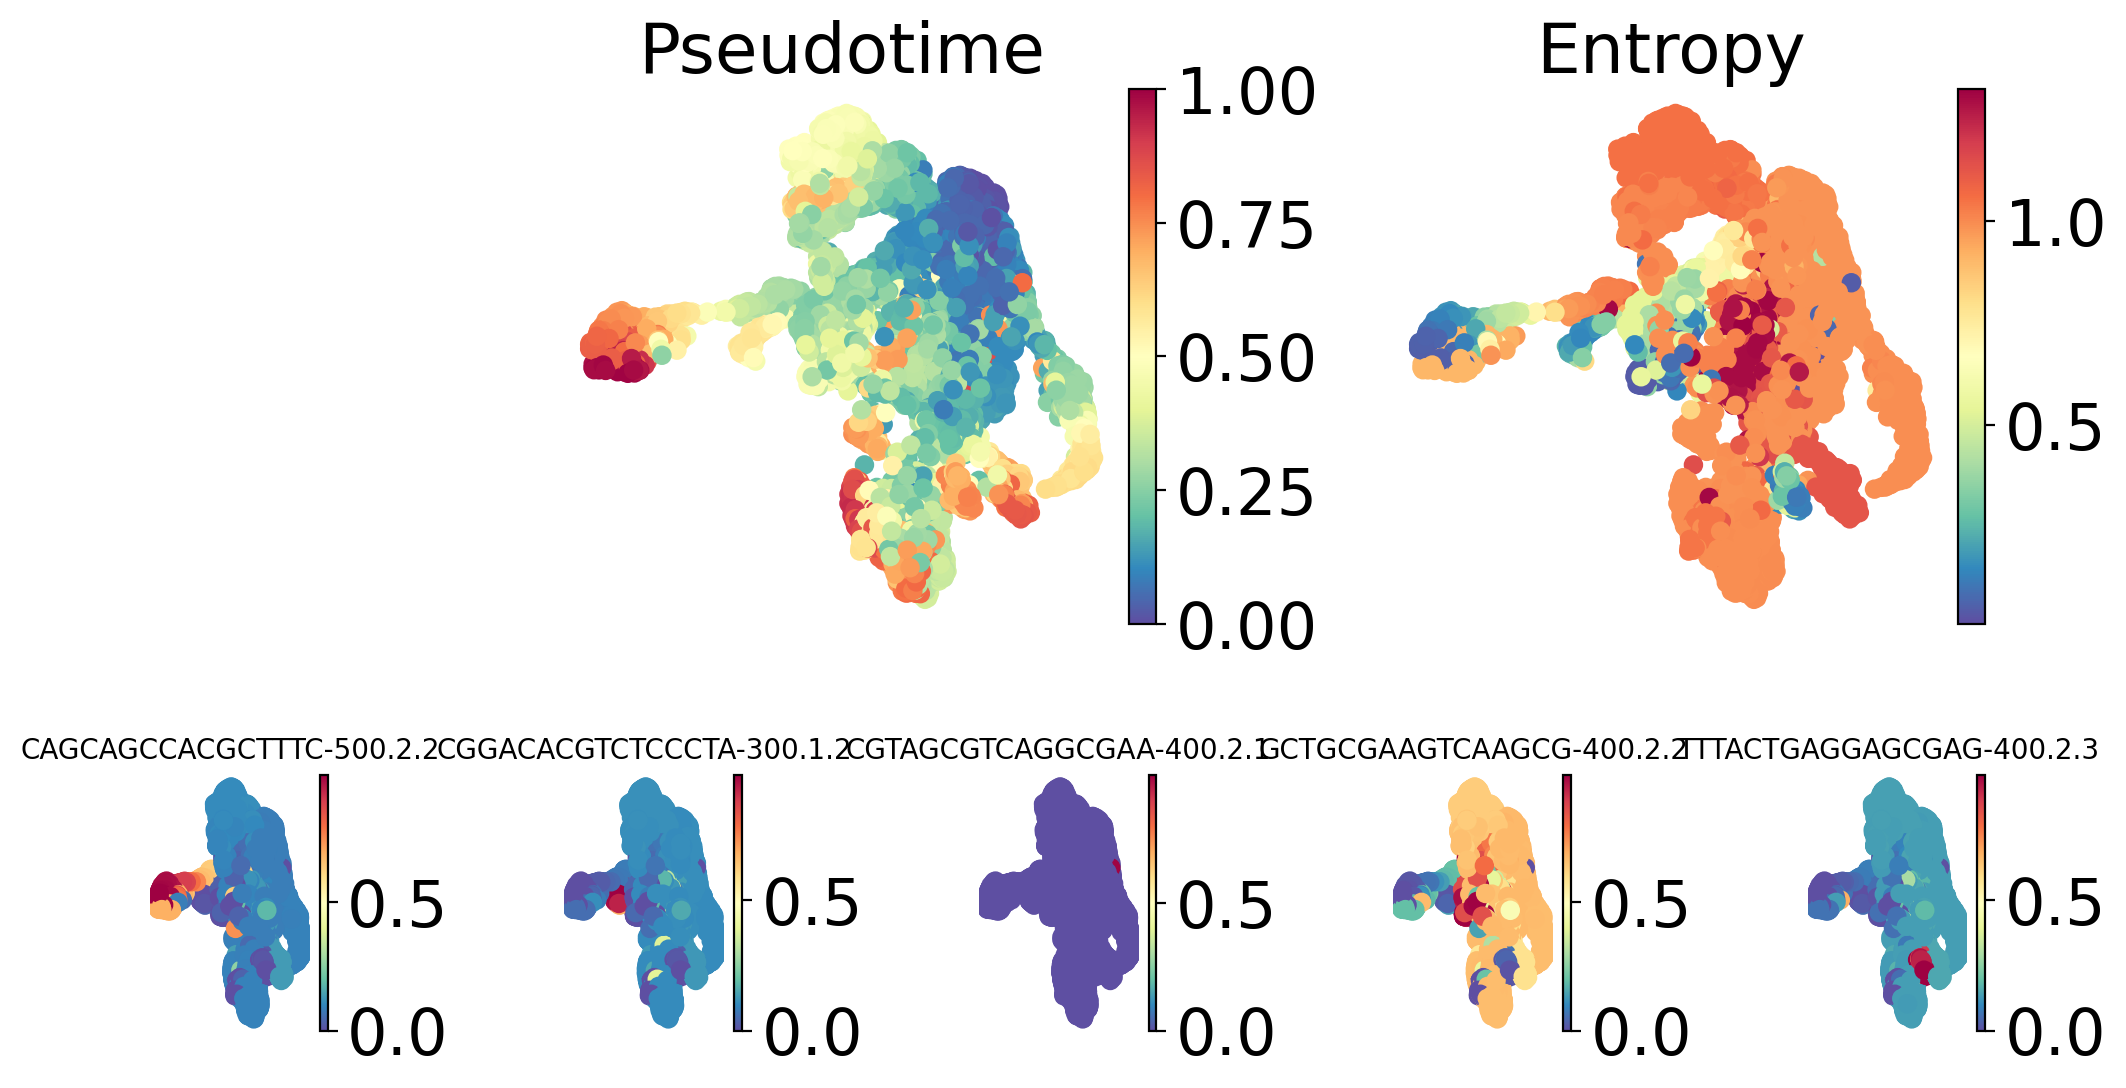

In [27]:
palantir.plot.plot_palantir_results(adata, pr_res)
plt.show()

## Run MAGIC

In [29]:
imp_df = palantir.utils.run_magic_imputation(adata, dm_res)

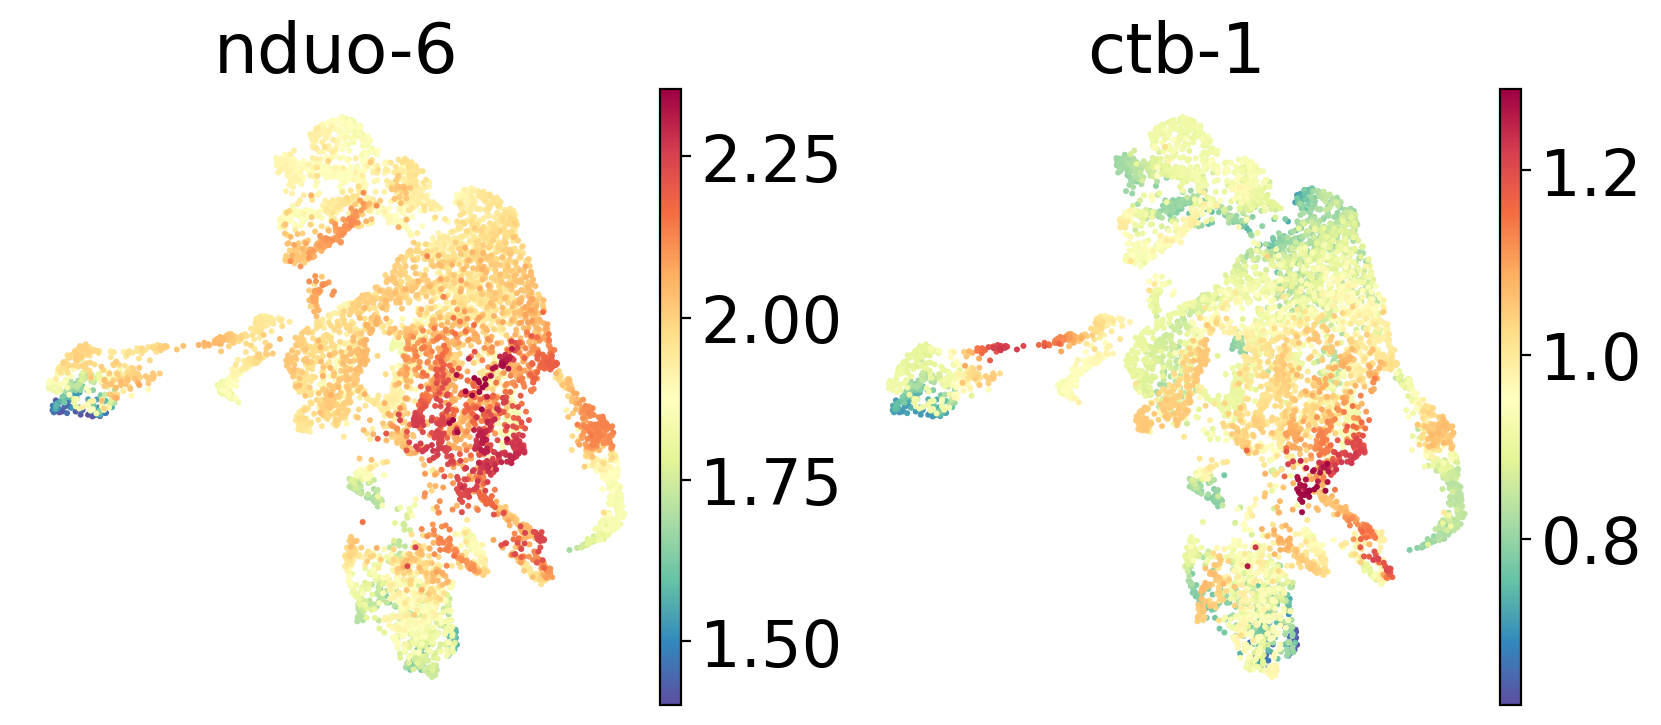

In [41]:
sc.pl.embedding(adata, basis='umap',  color=["nduo-6", "ctb-1"], layer='MAGIC_imputed_data', frameon=False)

## Write to AnnData

Actually to the writing. 

In [38]:
# save the pseudotime
adata.obs["palantir_pseudotime"] = pr_res.pseudotime.copy()

# save the imputed data
adata.layers["magic_imputed_data"] = np.array(imp_df)

## Write to file

In [40]:
if write_data:
    print("Writing data to file")
    palantir_pseudotime = sc.get.obs_df(adata, keys=["palantir_pseudotime"])
    magic_imputed_data = pd.DataFrame(
        data=adata.layers["magic_imputed_data"],
        index=adata.obs_names,
        columns=adata.var_names,
    )
    palantir_pseudotime.to_csv(
        DATA_DIR / "palantir" / "ML_2024-03-12_palantir_pseudotime.csv"
    )
    magic_imputed_data.to_csv(
        DATA_DIR / "palantir" / "ML_2024-03-12_magic_imputed_data.csv"
    )

Writing data to file
